# **IEEE-CIS Fraud Detection**

**Install libraries** 

In [1]:
!pip install pyfiglet
!pip install opendatasets

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#import sys
#sys.path.append('/content/drive/MyDrive/function')

# **Importation des librairies**

In [95]:
import numpy             as np # linear algebra
import pandas            as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn           as sns
import matplotlib.pyplot as plt
import opendatasets      as od
import functions
import warnings
import pyfiglet
import gc
import random

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from imblearn.over_sampling    import SMOTE
from sklearn.preprocessing     import StandardScaler
from sklearn.svm               import SVC
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, KFold, cross_validate
from sklearn.metrics           import accuracy_score
from sklearn.preprocessing     import RobustScaler
from sklearn.preprocessing     import LabelEncoder
from sklearn.ensemble          import VotingClassifier
from sklearn.ensemble          import StackingClassifier
from sklearn                   import preprocessing
from imblearn.metrics          import geometric_mean_score
from imblearn.metrics          import classification_report_imbalanced
from IPython.display           import HTML
from sklearn.metrics           import f1_score
from sklearn.metrics           import precision_score
from sklearn.metrics           import recall_score



In [5]:
ascii_banner = pyfiglet.figlet_format("PyFraudPredict models")
print(ascii_banner)

 ____        _____                    _ ____               _ _      _   
|  _ \ _   _|  ___| __ __ _ _   _  __| |  _ \ _ __ ___  __| (_) ___| |_ 
| |_) | | | | |_ | '__/ _` | | | |/ _` | |_) | '__/ _ \/ _` | |/ __| __|
|  __/| |_| |  _|| | | (_| | |_| | (_| |  __/| | |  __/ (_| | | (__| |_ 
|_|    \__, |_|  |_|  \__,_|\__,_|\__,_|_|   |_|  \___|\__,_|_|\___|\__|
       |___/                                                            
                     _      _     
 _ __ ___   ___   __| | ___| |___ 
| '_ ` _ \ / _ \ / _` |/ _ \ / __|
| | | | | | (_) | (_| |  __/ \__ \
|_| |_| |_|\___/ \__,_|\___|_|___/
                                  



**Suppression des Warnings**

In [6]:
warnings.simplefilter("ignore")

# **Récupération du dataset**

In [7]:
url="https://www.kaggle.com/c/ieee-fraud-detection/data"
od.download(url)

Skipping, found downloaded files in ".\ieee-fraud-detection" (use force=True to force download)


**Chargement des différents dataset**

In [ ]:
%%time
sample              = pd.read_csv("ieee-fraud-detection/sample_submission.csv")
df_identity         = pd.read_csv("ieee-fraud-detection/train_identity.csv")
df_transaction      = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
df_test_transaction = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
df_test_identity    = pd.read_csv("ieee-fraud-detection/test_identity.csv")

**Merge train and test data**

In [9]:
train = df_transaction.merge(df_identity, how="left", on="TransactionID")
test  = df_test_transaction.merge(df_test_identity, how="left", on="TransactionID")

**Reduction de la mémoire**

In [ ]:
%%time
sample    = functions.reduce_mem_usage(sample)
train     = functions.reduce_mem_usage(train)
test      = functions.reduce_mem_usage(test)

In [ ]:
gc.collect()

# **1- Analyse exploratoire**





**Sample dataset**

In [ ]:
sample.info()


In [ ]:
sample.head(3)

In [ ]:
sample['isFraud'].unique()

**Remarque:**  La variable cible "isFraud" du dataset "sample_submission" se compose uniquement de la valeur 0.5. Ceci rend ce dataset inutilisable en dehors de la compétation kaggle.

**Train dataset**

In [ ]:
print("Train dataset identity")
train.head(5)

In [ ]:
train.info()

In [ ]:
train.describe(include="all")

In [ ]:
train.shape

In [ ]:
print("Nombre d'observation ayant des valeurs manquantes: ", train.isnull().any(axis = 1).sum())

**Remarque:** Chaque observation contient au moins une valeur manquante

In [ ]:
print("Nombre de features ayant des valeurs manquantes: ", train.isnull().any(axis = 0).sum())

In [ ]:
plot_width, plot_height = (20,90)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
functions.plot_nas(train)

**Elimination des features ayant plus de 75% de valeurs manquantes**

In [ ]:
treshold = 75.0
min_count =  int(((100-treshold)/100)*train.shape[0] + 1)
train = train.dropna( axis=1, 
                thresh=min_count)

In [ ]:
print("Nombre de valeurs manquantes dans la train dataset: ", train.isnull().sum().sum())

**Imputation des valeurs manquantes**

In [24]:
%%time
train = functions.fill_miss_val(train)

Nombre de valeur manquantes après l'imputation:  0
Wall time: 23min 54s


In [25]:
gc.collect()

58363

In [26]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,0.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Boxplot d'un sous ensemble de features du train dataset**

In [27]:
train.shape

(590540, 226)

<AxesSubplot:>

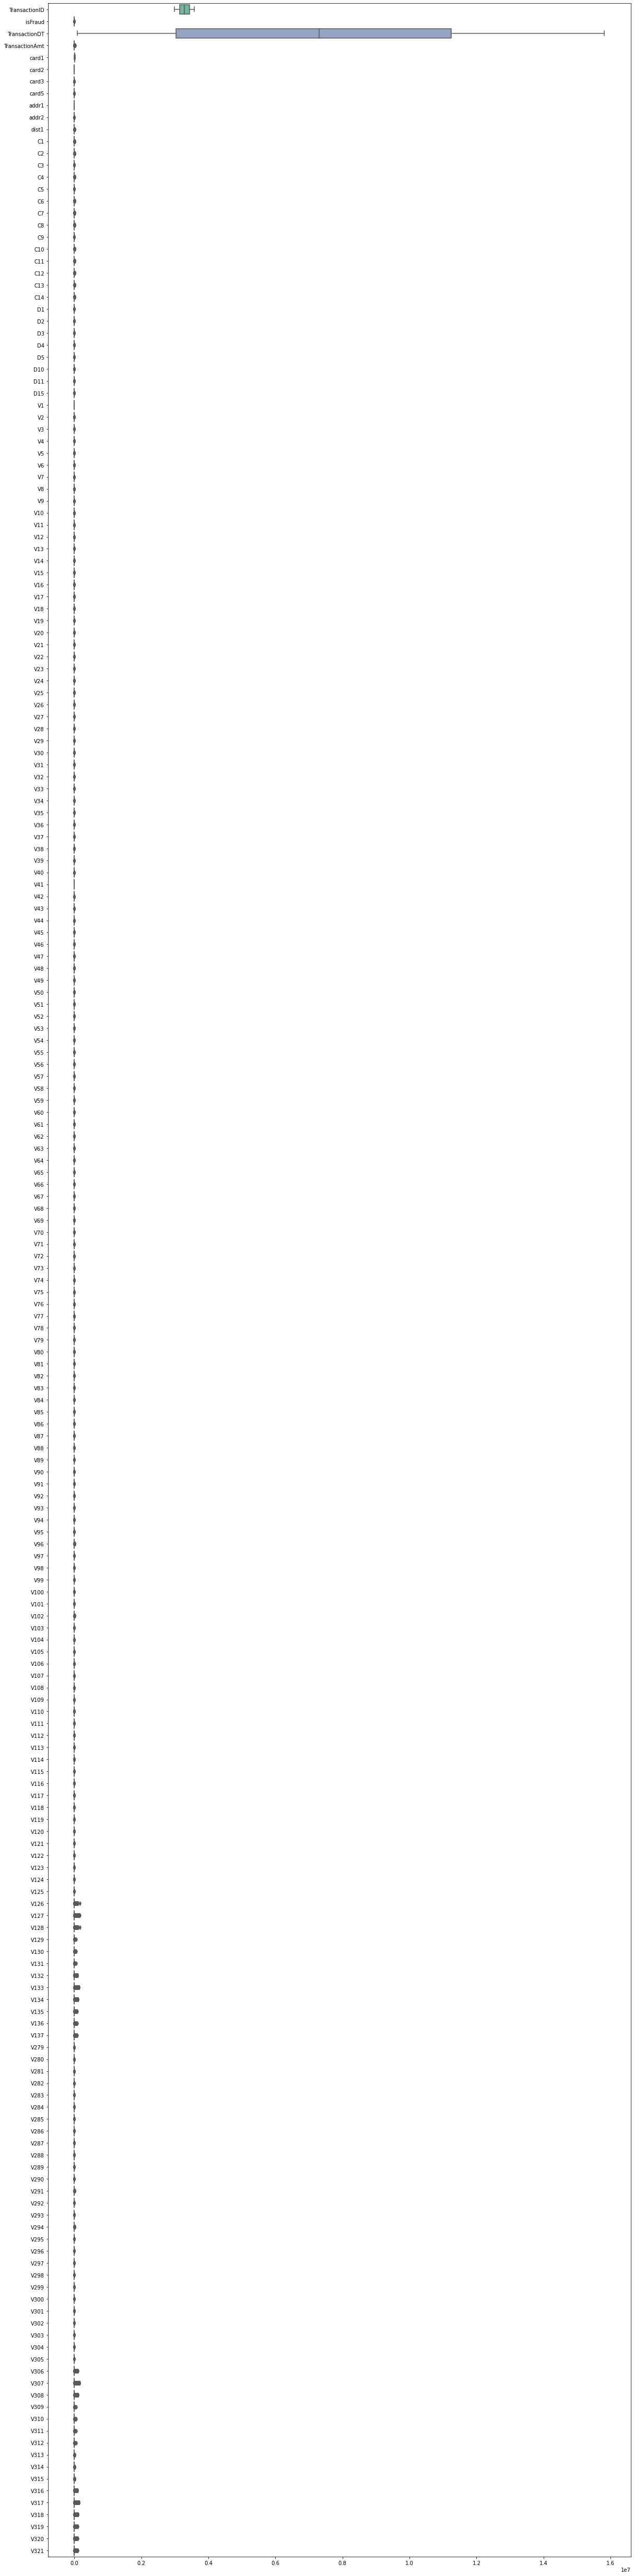

In [28]:
sns.boxplot(data=train, orient="h", palette="Set2")

**Remarque:** Ce graphe nous montre qu'il y'a pas d'outlier dans le train

**Histogram**

Wall time: 14 s


array([[<AxesSubplot:title={'center':'TransactionID'}>,
        <AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'TransactionAmt'}>,
        <AxesSubplot:title={'center':'card1'}>,
        <AxesSubplot:title={'center':'card2'}>,
        <AxesSubplot:title={'center':'card3'}>,
        <AxesSubplot:title={'center':'card5'}>,
        <AxesSubplot:title={'center':'addr1'}>,
        <AxesSubplot:title={'center':'addr2'}>,
        <AxesSubplot:title={'center':'dist1'}>,
        <AxesSubplot:title={'center':'C1'}>,
        <AxesSubplot:title={'center':'C3'}>,
        <AxesSubplot:title={'center':'C5'}>,
        <AxesSubplot:title={'center':'C7'}>,
        <AxesSubplot:title={'center':'C9'}>,
        <AxesSubplot:title={'center':'C13'}>],
       [<AxesSubplot:title={'center':'D1'}>,
        <AxesSubplot:title={'center':'D3'}>,
        <AxesSubplot:title={'center':'D4'}>,
        <AxesSubplot:title={'center':'D5'}>,
        <AxesSubplot:title={'center':'D10'}>,
   

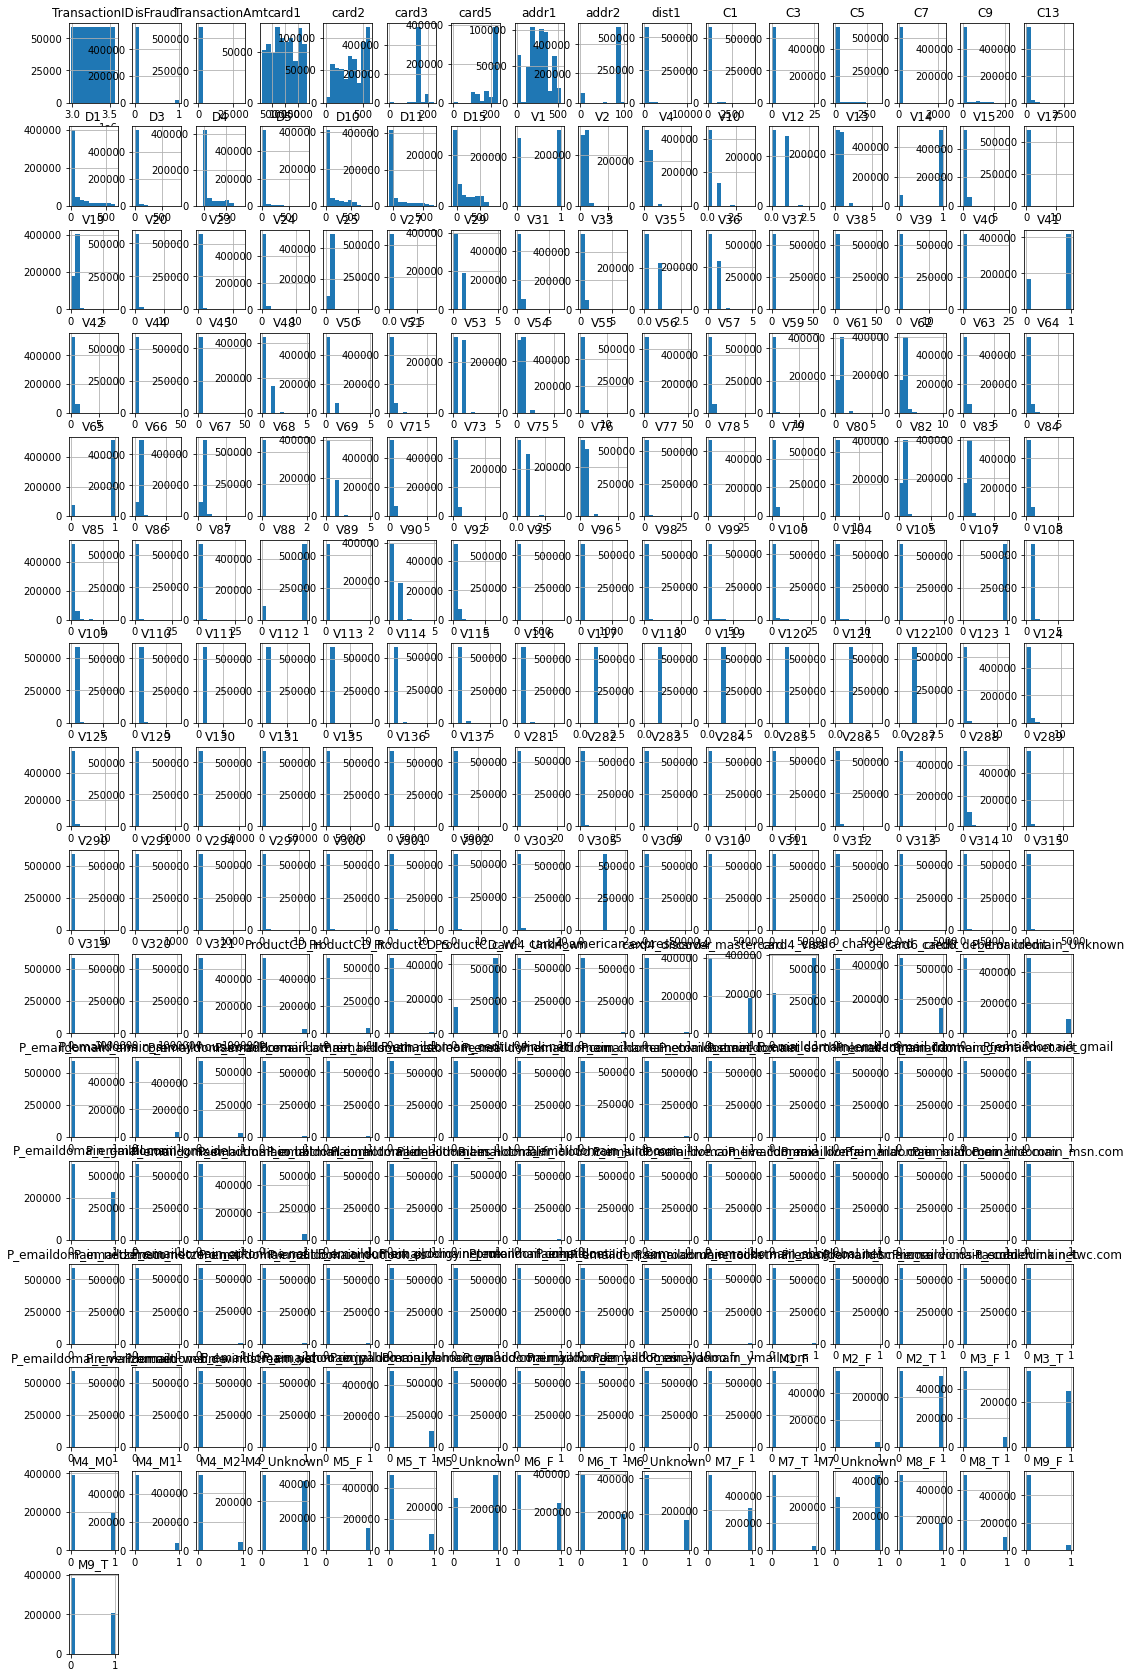

In [203]:
%%time
train.hist(figsize=(18,30));

**Analyse de la variable cible**

In [30]:
train['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

<AxesSubplot:xlabel='isFraud', ylabel='count'>

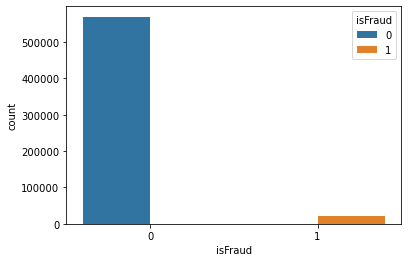

In [205]:
sns.countplot(x="isFraud", hue="isFraud", data=train)

**Remarque:** Nous constatons ici que le train dataset contient pratiquement 96% d'observations non frauduleuse. Nous sommes donc face à un dataset contenant des classes déséquilibrés. Un modèle basé sur ce dataset est susceptible de produire un modèle biaisé. Par la suite, il faudra donc reéchantillonné le dataset pour pouvoir obtenir un modèle avec des prédictions non biaisés.  

**Encodage des valeurs categorielle**

In [31]:
gc.collect()

105

In [32]:
train = functions.encode_df(train)

**Analyse de la correlation: suppression des variables fortement correlées**

In [33]:
# correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Suppression des features 
train.drop(to_drop, axis=1, inplace=True)

In [34]:
gc.collect()

0

In [35]:
train.shape

(590540, 241)

**Test dataset**

In [36]:
test.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
if ('isFraud' not in test.columns) and ('isFraud' not in test.columns):
    print(" Le dataframe de test ne contient pas de la variable cible 'isFraud'. Ceci rend ce dataframe inutilisable dans le cadre de notre projet.\n\n Pour la suite, nous allons donc utiliser principalement les dataframe Train")

 Le dataframe de test ne contient pas de la variable cible 'isFraud'. Ceci rend ce dataframe inutilisable dans le cadre de notre projet.

 Pour la suite, nous allons donc utiliser principalement les dataframe Train


**Train test split**

In [38]:
feats  = train.drop('isFraud', axis=1)
target = train.isFraud
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25)

In [39]:
gc.collect()

0

**Features selection**

In [40]:
X_train_fs, X_test_fs = functions.select_features(X_train, y_train, X_test)

In [41]:
gc.collect()

0

**Features scaling**

In [42]:
#feature scaling with robustScaler
transformer = RobustScaler().fit(X_train_fs)
X_train = transformer.transform(X_train_fs)
X_test  = transformer.transform(X_test_fs)

In [43]:
gc.collect()

0

**Dataset resampling with SMOTE**

In [44]:
#Dataset resampling with SMOTE: 
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon SMOTE : {0: 427385, 1: 427385}


In [45]:
gc.collect()

0

# **2- Entrainement et optimisation des hyperparamètres**

## Les différentes étapes

<br>
<details><summary>Cliquer ici pour plus de détails</summary>
<p> 


    * Entrainement de différents modèles d'apprentissage supervisé
        - optimisation des hyperparamètres en utilisant du gridsearch
        - Evaluation des performances en considérant les métriques suivantes: accuracy, gmean, precision, f1-score, precision et recall
    * Entrainement d'un modèle d'apprentissage non supervisé
        - Evaluation des performances
    * Sélection d'un modèle en considérent le f1-score et le gmean
    * Sauvegarde du meilleur modèle



</p>

# A- Apprentissage supervisé

**1- Lightgbm model**


In [46]:
# build the lightgbm model
import lightgbm as lgb

clf_lgb = lgb.LGBMClassifier()
params_lgb = {
    'num_leaves':[20,40,60,80,100], 
    'min_data_in_leaf':[200,300,400],
    'max_depth':[4,6,8],
    'learning_rate':[0.05,0.1,0.2],
}

gridcv_lgb = GridSearchCV(clf_lgb, param_grid=params_lgb, scoring='accuracy', cv=3)   

In [47]:
gridcv_lgb.fit(X_sm, y_sm)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'min_data_in_leaf': [200, 300, 400],
                         'num_leaves': [20, 40, 60, 80, 100]},
             scoring='accuracy')

In [109]:
#pd.DataFrame(gridcv_lgb.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

In [49]:
gridcv_lgb.best_params_

{'learning_rate': 0.2,
 'max_depth': 8,
 'min_data_in_leaf': 300,
 'num_leaves': 100}

In [50]:
pred_lgb=gridcv_lgb.predict(X_test)

In [111]:
accuracy_LightGBM  = accuracy_score(y_test, pred_lgb)

In [112]:
gmean_LightGBM     = geometric_mean_score(y_test, pred_lgb, average='micro')

In [113]:
f1score_LightGBM   = f1_score(y_test, pred_lgb, average='micro')

In [114]:
precision_LightGBM = precision_score(y_test, pred_lgb, average='micro')

In [115]:
recall_LightGBM    = recall_score(y_test, pred_lgb, average='micro')

In [110]:
#print('Test set score: {:.4f}'.format(accuracy_score(y_test, pred_lgb)))

In [52]:
from sklearn.metrics import classification_report
print("Classication report for lightgbm: \n")
print(classification_report(y_test, pred_lgb))

Classication report for lightgbm: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142492
           1       0.45      0.49      0.47      5143

    accuracy                           0.96    147635
   macro avg       0.71      0.73      0.72    147635
weighted avg       0.96      0.96      0.96    147635



In [53]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, pred_lgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.98      0.49      0.98      0.69      0.50    142492
          1       0.45      0.49      0.98      0.47      0.69      0.46      5143

avg / total       0.96      0.96      0.51      0.96      0.69      0.50    147635



In [72]:
lgb_gmean_lightgbm = geometric_mean_score(y_test, pred_lgb, average='micro')

**Confusion Matrix**

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_lgb)

In [56]:

print('Confusion matrix\n\n', cm)
#print('\nTrue Positives(TP) = ', cm[0,0])
#print('\nTrue Negatives(TN) = ', cm[1,1])
#print('\nFalse Positives(FP) = ', cm[0,1])
#print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[139348   3144]
 [  2614   2529]]


**2- LogisticRegression**

In [57]:
clf_lr = LogisticRegression(random_state=22, max_iter=1000)
param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-1, 1, 4)}

gridcv_lr = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring='accuracy', cv=3)  
gridcv_lr.fit(X_sm, y_sm)


In [75]:
final_lr     = gridcv_lr.predict(X_test)

In [76]:
lr_accuracy  = accuracy_score(y_test, final_lr)

In [88]:
lr_gmean     = geometric_mean_score(y_test, final_lr, average='micro')

In [92]:
lr_f1score   = f1_score(y_test, final_lr, average='micro') 

In [94]:
lr_precision = precision_score(y_test, final_lr, average='micro') 

In [96]:
lr_recall    = recall_score(y_test, final_lr, average='micro') 

In [77]:
print("Classication report for Logistic Regression: \n")
print(classification_report(y_test, final_lr))

Classication report for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.99      0.74      0.85    142492
           1       0.09      0.73      0.16      5143

    accuracy                           0.74    147635
   macro avg       0.54      0.74      0.51    147635
weighted avg       0.96      0.74      0.82    147635



In [78]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, final_lr))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.74      0.73      0.85      0.74      0.54    142492
          1       0.09      0.73      0.74      0.16      0.74      0.54      5143

avg / total       0.96      0.74      0.73      0.82      0.74      0.54    147635



In [79]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, final_lr))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.74      0.73      0.85      0.74      0.54    142492
          1       0.09      0.73      0.74      0.16      0.74      0.54      5143

avg / total       0.96      0.74      0.73      0.82      0.74      0.54    147635



**3- RandomForest**

In [61]:

clf_rf = RandomForestClassifier(random_state=22)
param_grid_rf = [{'n_estimators': [10, 50, 100], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

gridcv_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring='accuracy', cv=3)  
gridcv_rf.fit(X_sm, y_sm)
final_rf=gridcv_rf.predict(X_test)

In [62]:
test_rf_acc  = accuracy_score(y_test, final_rf)

In [116]:
rf_gmean     = geometric_mean_score(y_test, final_rf, average='micro')

In [117]:
rf_f1score   = f1_score(y_test, final_rf, average='micro') 

In [118]:
rf_precision = precision_score(y_test, final_rf, average='micro') 

In [119]:
rf_recall    = recall_score(y_test, final_rf, average='micro') 

In [63]:
print("Classication report for random forest: \n")
print(classification_report(y_test, final_rf))

Classication report for random forest: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142492
           1       0.48      0.51      0.49      5143

    accuracy                           0.96    147635
   macro avg       0.73      0.75      0.74    147635
weighted avg       0.96      0.96      0.96    147635



In [64]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, final_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.98      0.51      0.98      0.71      0.52    142492
          1       0.48      0.51      0.98      0.49      0.71      0.48      5143

avg / total       0.96      0.96      0.53      0.96      0.71      0.52    147635



**4- StackingClassifier**

In [101]:
cv3 = KFold(n_splits=3, random_state=111, shuffle = True)

sclf = StackingClassifier(estimators=[('LR', clf_lr), ('rf', clf_rf)], 
                          final_estimator= gridcv_lgb)

scores = cross_validate(sclf, X_sm, y_sm, 
                                              cv=cv3, scoring=['accuracy','f1'])
print("[StackingClassifier]: \n Accuracy: %0.2f (+/- %0.2f)\n" 
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
      "F1 score: %0.2f (+/- %0.2f)"
      % (scores['test_f1'].mean(), scores['test_f1'].std()))


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGB

In [102]:
sclf.fit(X_sm, y_sm)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


StackingClassifier(estimators=[('LR',
                                LogisticRegression(max_iter=1000,
                                                   random_state=22)),
                               ('rf', RandomForestClassifier(random_state=22))],
                   final_estimator=GridSearchCV(cv=3,
                                                estimator=LGBMClassifier(),
                                                param_grid={'learning_rate': [0.05,
                                                                              0.1,
                                                                              0.2],
                                                            'max_depth': [4, 6,
                                                                          8],
                                                            'min_data_in_leaf': [200,
                                                                                 300,
                                  

In [103]:
pred_sclf      = sclf.predict(X_test)

In [104]:
sclf_accuracy  = accuracy_score(y_test, pred_sclf)

In [105]:
sclf_gmean     = geometric_mean_score(y_test, pred_sclf, average='micro')

In [106]:
sclf_f1score   = f1_score(y_test, pred_sclf, average='micro') 

In [107]:
sclf_precision = precision_score(y_test, pred_sclf, average='micro') 

In [108]:
sclf_recall    = recall_score(y_test, pred_sclf, average='micro')  

In [68]:
print("Classication report for StackingClassifier : \n")
print(classification_report(y_test, sclf.predict(X_test)))

Classication report for StackingClassifier : 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    142492
           1       0.42      0.54      0.48      5143

    accuracy                           0.96    147635
   macro avg       0.70      0.76      0.73    147635
weighted avg       0.96      0.96      0.96    147635



In [179]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, sclf.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.98      0.52      0.98      0.72      0.54    142492
          1       0.48      0.52      0.98      0.50      0.72      0.49      5143

avg / total       0.97      0.96      0.54      0.96      0.72      0.53    147635



**Performance evaluation**

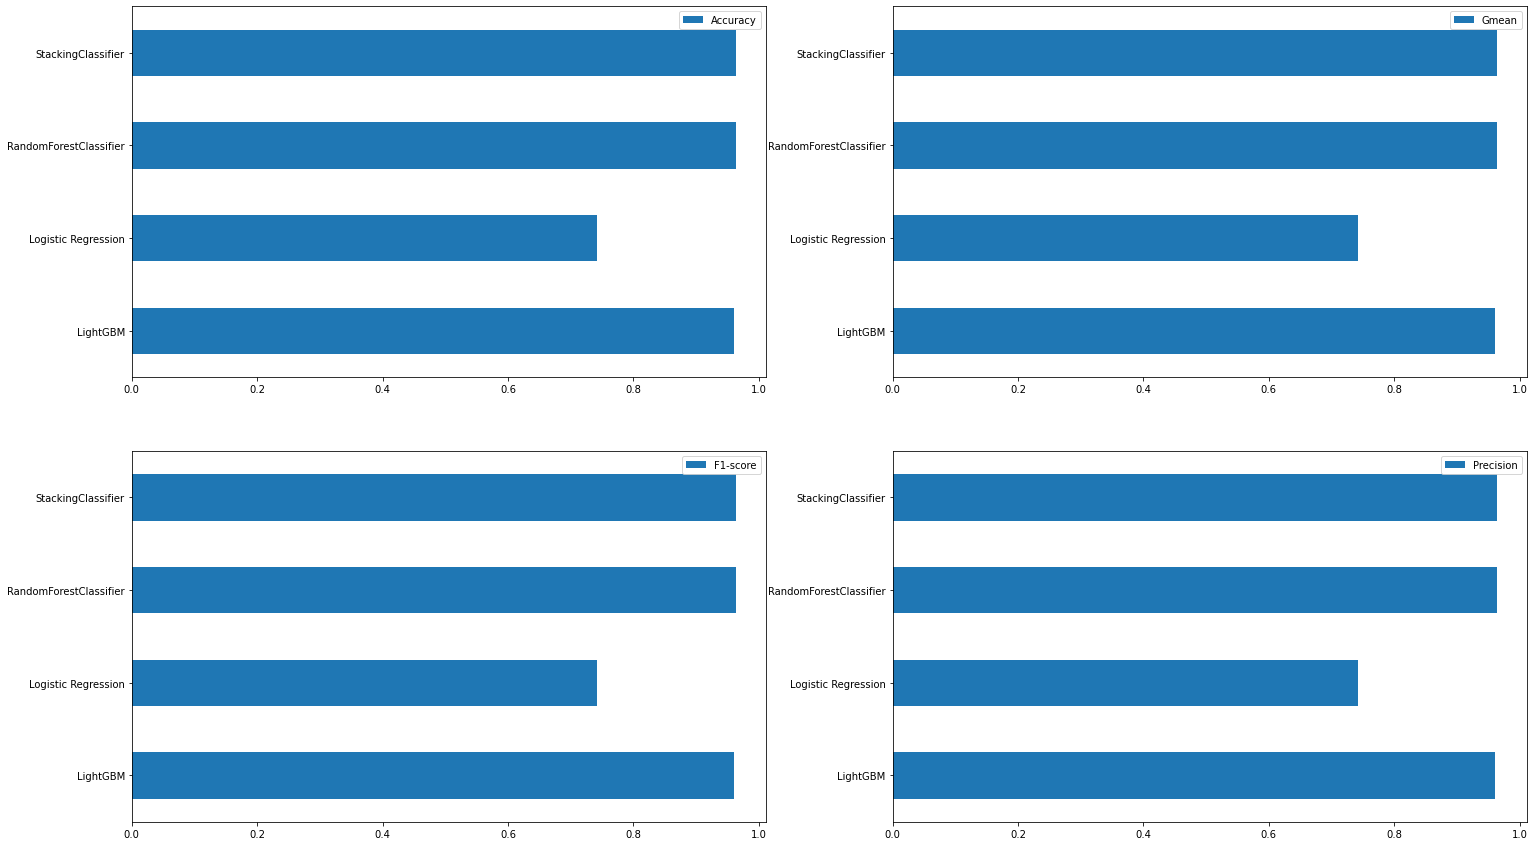

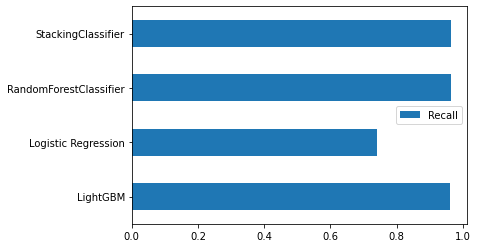

In [220]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#plt.subplot(2,2,1)
#plt.figure(figsize=(15,15))

data = {'Accuracy': [accuracy_LightGBM,lr_accuracy,test_rf_acc,sclf_accuracy]}
df_acc = pd.DataFrame(data,columns=['Accuracy'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','StackingClassifier'])

data_gmean= {'Gmean':[gmean_LightGBM, lr_gmean, rf_gmean,  sclf_gmean ]}
df_gmean = pd.DataFrame(data_gmean,columns=['Gmean'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','StackingClassifier'])

data_f1score= {'F1-score':[f1score_LightGBM, lr_f1score, rf_f1score, sclf_f1score]}
df_f1score = pd.DataFrame(data_f1score,columns=['F1-score'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','StackingClassifier'])

data_precision= {'Precision':[precision_LightGBM, lr_precision, rf_precision, sclf_precision]}
df_precision = pd.DataFrame(data_precision,columns=['Precision'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','StackingClassifier'])

data_recall= {'Recall':[recall_LightGBM, lr_recall,  rf_recall, sclf_recall]}
df_recall = pd.DataFrame(data_recall,columns=['Recall'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','StackingClassifier'])


df_acc.plot.barh(ax=axes[0,0], figsize=(25,15))
df_gmean.plot.barh(ax=axes[0,1])
df_f1score.plot.barh(ax=axes[1,0])
df_precision.plot.barh(ax=axes[1,1])
df_recall.plot.barh()

#plt.title('Evaluation de la performance des modèles d\'apprentissage supervisé')
#plt.ylabel('Model')
#plt.xlabel('Accuracy')
plt.show()

# B- Apprentissage non supervisé

**1- Isolation forest**

In [126]:
from sklearn.ensemble import IsolationForest

In [127]:
clf_isolation=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.01),max_features=1.0)
clf_isolation.fit(X_sm)

IsolationForest(contamination=0.01, n_estimators=50)

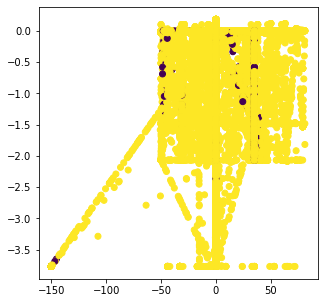

In [137]:
plt.figure(figsize=(5,5))
plt.scatter(X_sm[:,0],X_sm[:,1], c=clf_isolation.predict(X_sm))

In [150]:
data = {'Score':clf_isolation.decision_function(X_sm), 'Anomaly':clf_isolation.predict(X_sm)}  
dfIso = pd.DataFrame(data)  
dfIso.head()

,Score,Anomaly
0,0.086018,1
1,0.168816,1
2,0.167058,1
3,0.088441,1
4,0.137824,1


In [163]:
test_data =np.array(y_test)
dfPred = pd.DataFrame({ 'Pred': clf_isolation.predict(X_test)}, columns=['Pred'])
#Recall:
#1: fraudulent transaction. 0: normal transaction
dfPred["Pred"].replace({-1: 1, 1: 0}, inplace=True)
dfPred.head()

,Pred
0,0
1,0
2,0
3,0
4,0


In [206]:
#dfPred["Pred"].value_counts()

In [165]:
dfPred['Real'] = test_data

In [180]:
iso_acc       = accuracy_score(y_test, dfPred["Pred"])

In [181]:
iso_gmean     = geometric_mean_score(y_test, dfPred["Pred"], average='micro')

In [182]:
iso_f1score   = f1_score(y_test, dfPred["Pred"], average='micro') 

In [183]:
iso_precision = precision_score(y_test, dfPred["Pred"], average='micro') 

In [184]:
iso_recall    = recall_score(y_test, dfPred["Pred"], average='micro')  

In [169]:
print("Classication report for isolation forest: \n")
print(classification_report(y_test, dfPred["Pred"]))

Classication report for isolation forest: 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142492
           1       0.45      0.02      0.04      5143

    accuracy                           0.96    147635
   macro avg       0.71      0.51      0.51    147635
weighted avg       0.95      0.96      0.95    147635



In [170]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, dfPred["Pred"]))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      1.00      0.02      0.98      0.15      0.02    142492
          1       0.45      0.02      1.00      0.04      0.15      0.02      5143

avg / total       0.95      0.96      0.06      0.95      0.15      0.02    147635



# **C- Compraison des performances**

In [188]:
# initialize list of lists

data = {"Lightgbm": [gmean_LightGBM, f1score_LightGBM, precision_LightGBM, recall_LightGBM],
        "Logistic regression": [lr_gmean, lr_f1score, lr_precision, lr_recall],
        "Random forest": [rf_gmean, rf_f1score, rf_precision, rf_recall],
        "StackingClassifier": [sclf_gmean, sclf_f1score, sclf_precision, sclf_recall],
        "Isolation forest": [iso_gmean, iso_f1score, iso_precision, iso_recall],
       }
# Create the pandas DataFrame
df_performance = pd.DataFrame(data, index=['Gmean', 'F1-score', 'Precision', 'Recall'])
df_performance

,Lightgbm,Logistic regression,Random forest,StackingClassifier,Isolation forest
Gmean,0.960998,0.741579,0.963511,0.963417,0.964988
F1-score,0.960998,0.741579,0.963511,0.963417,0.964988
Precision,0.960998,0.741579,0.963511,0.963417,0.964988
Recall,0.960998,0.741579,0.963511,0.963417,0.964988


# **3- Sauvegarde du model**

In [189]:
from joblib import dump, load
import joblib

In [191]:
# save the model to disk

In [198]:
filename = 'best_model.sav'
joblib.dump(clf_isolation, filename)


['best_model.sav']

In [192]:
 # load the model from disk

In [199]:
loaded_model = joblib.load(filename)
result = loaded_model.predict(X_test)
print(result)

[1 1 1 ... 1 1 1]
